In [1]:
%run Cisco\ Common.ipynb

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
from prettytable import PrettyTable

cisco_resource_id = 93036
data = get_cisco_vuln_data(cisco_resource_id)
display(HTML("<h1>Cisco Monthly Vulnerability Feed</h1>"))
if data:
    display(HTML(get_cisco_vuln_table(data)))
else:
    display(HTML("<h2><i>No items in feed</i></h2>"))

Identifer,Severity,Title,ciscoBugId,Last Published
cisco-sa-20200108-ios-csrf,High,Cisco IOS and Cisco IOS XE Software Web UI Cross-Site Request Forgery Vulnerability,CSCvq66030,2020-01-08
cisco-sa-20190925-ftp,High,"Cisco IOS XE Software FTP Application Layer Gateway for NAT, NAT64, and ZBFW Denial of Service Vulnerability",CSCvn02419,2019-11-20
cisco-sa-20190828-iosxe-rest-auth-bypass,Critical,Cisco REST API Container for IOS XE Software Authentication Bypass Vulnerability,CSCvn93524CSCvo47376,2019-10-18
cisco-sa-20190925-webui-cmd-injection,High,Cisco IOS XE Software Web UI Command Injection Vulnerabilities,CSCvo61821CSCvp78858CSCvp95724,2019-10-14
cisco-sa-20190925-sip-dos,High,Cisco IOS and IOS XE Software Session Initiation Protocol Denial of Service Vulnerability,CSCvn00218,2019-10-04
cisco-sa-20190925-sip-alg,High,Cisco IOS XE Software NAT Session Initiation Protocol Application Layer Gateway Denial of Service Vulnerability,CSCvn65912,2019-09-25
cisco-sa-20190925-rawtcp-dos,High,Cisco IOS XE Software Raw Socket Transport Denial of Service Vulnerability,CSCvj91021,2019-09-25
cisco-sa-20190925-iosxe-fsdos,High,Cisco IOS XE Software Filesystem Exhaustion Denial of Service Vulnerability,CSCvf80363,2019-09-25
cisco-sa-20190925-utd,High,Cisco IOS XE Software Unified Threat Defense Denial of Service Vulnerability,CSCvn29244,2019-09-25
cisco-sa-20190925-iosxe-digsig-bypass,High,Cisco IOS XE Software Digital Signature Verification Bypass Vulnerability,CSCvj87117CSCvk12460,2019-09-25


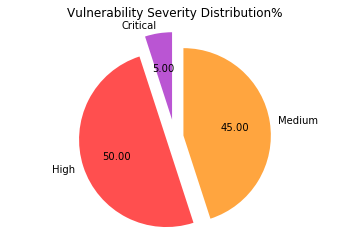

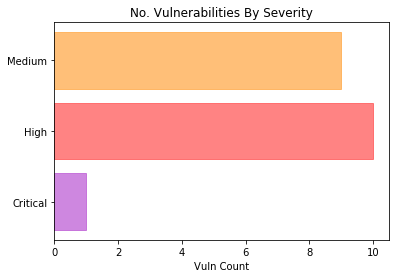

In [3]:
show_severity_breakdown(group(data, lambda x: x['severity']))

In [4]:
from concurrent.futures import ThreadPoolExecutor
dates = [d.strftime("%Y+%b") for d in months_backwards(12)]
with ThreadPoolExecutor(max_workers=5) as executor:
    monthly_data = {
        date: group(vuln_data, lambda x: x['severity']) 
        for date, vuln_data in
        executor.map(lambda d: (d, get_cisco_vuln_data(cisco_resource_id, d)), dates)
    }

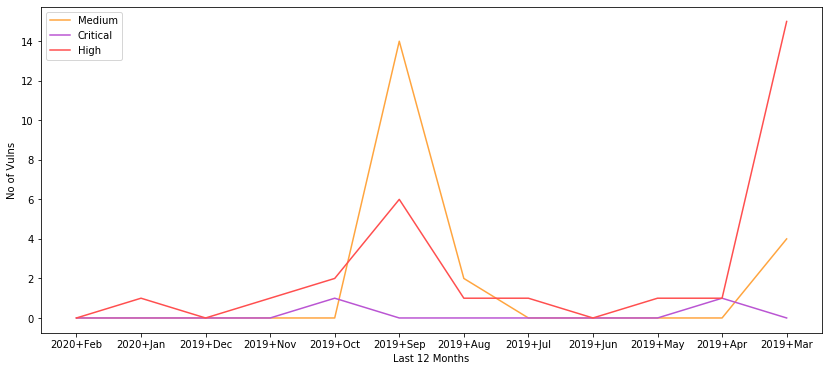

In [5]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from itertools import chain

severities = set(chain.from_iterable(v.keys() for k,v in monthly_data.items()))

display(HTML("<h2>Cisco Annual Vulnerabilities Tracker</h2>"))
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(111)
for s in severities:
    plt.plot(dates,[len(v[s]) for k, v in monthly_data.items()], color=cvss_severity_colors[s],label=s)
plt.xlabel('Last 12 Months')
plt.ylabel('No of Vulns')
plt.legend(loc=2)
plt.show()